# load insolation data

In [58]:
import pandas as pd
import numpy as np

# load orbital parameters
path='D:/VScode/EBM_NH_SH_sea_ice/orb_paras/'
# read the Pre_0_1Ma_inter100.txt, which does not have columns names
df_pre=pd.read_csv(path+'Pre_0_1Ma_inter100.txt',sep='\s+',header=None)
# rename the columns
df_pre.columns=['age','pre']

df_obl=pd.read_csv(path+'Obl_0_1Ma_inter100.txt',sep='\s+',header=None)
df_obl.columns=['age','obl']


df_pre['age']=df_pre['age']*-1
df_obl['age']=df_obl['age']*-1
# filp the columns up-down
df_pre=df_pre[::-1]
df_obl=df_obl[::-1]




# # timing of the terminations, data from Huybers et al., 2011 doi:10.1038/nature10626
Tt=np.array([-957,-864,-794,-714,-622,-538,-423,-326,-231,-208,-124,-11])*-1
Tt_unc_sigleside=np.array([9.19599874163397,8.11472231168675,8.29531938444627,8.90935954302480,9.05842898966959,8.80897810886163,8.31862132608857,8.17091882229411,7.55216739617228,7.25855162019460,5.37345911115918,1.77207101844172])

df_pre

,age,pre
10000,-0.0,0.016280
9999,0.1,0.016431
9998,0.2,0.016568
9997,0.3,0.016690
9996,0.4,0.016798
...,...,...
4,999.6,-0.032710
3,999.7,-0.033019
2,999.8,-0.033297
1,999.9,-0.033544


dict_keys(['__header__', '__version__', '__globals__', 't', 'V'])


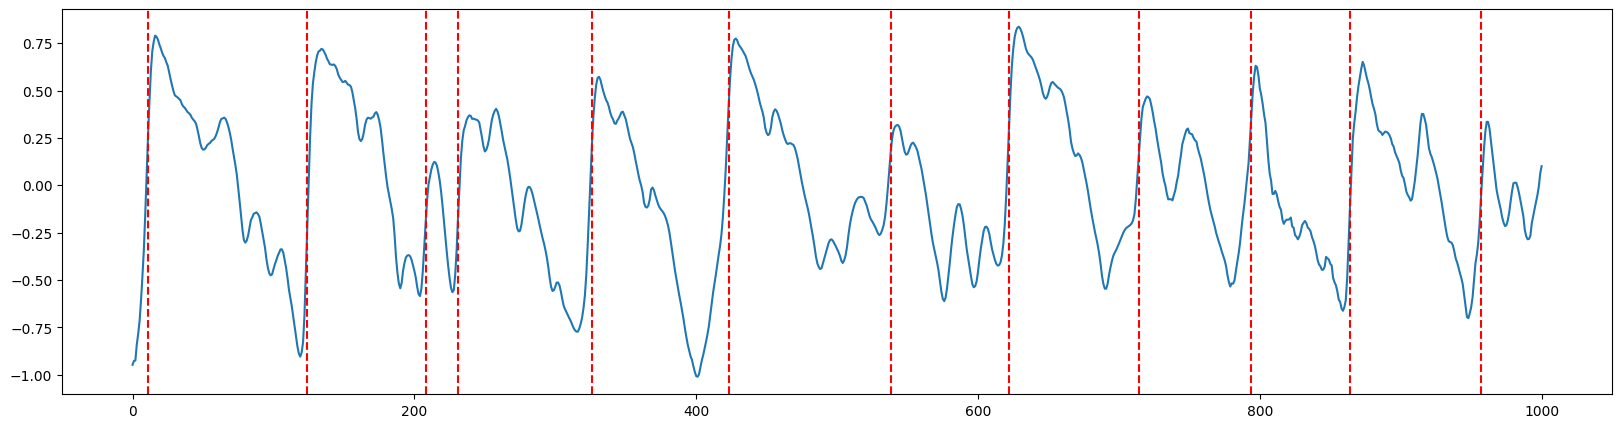

In [79]:
from scipy.io import loadmat
from scipy.signal import find_peaks

# Load the file
file_path ='D:/VScode/EBM_NH_SH_sea_ice/proxy_data/fig1_delta18O_record_Huybers2007.mat'

data = loadmat(file_path)

# Access data
print(data.keys())  # Shows all variables
t = data['t']  # Replace 'variable_name' with your variable
V= data['V']

# creat a dataframe
df_huybers_d18O=pd.DataFrame({'age':t[0,:].T,'d18O':V[0,:].T})
# age*-1
df_huybers_d18O['age']=df_huybers_d18O['age']*-1

import matplotlib.pyplot as plt
# create a figure and axis
plt.figure(figsize=(20,5))
plt.plot(df_huybers_d18O['age'],df_huybers_d18O['d18O'])
# plot Tt as vertical lines
for i in Tt:
    plt.axvline(x=i, color='r', linestyle='--')



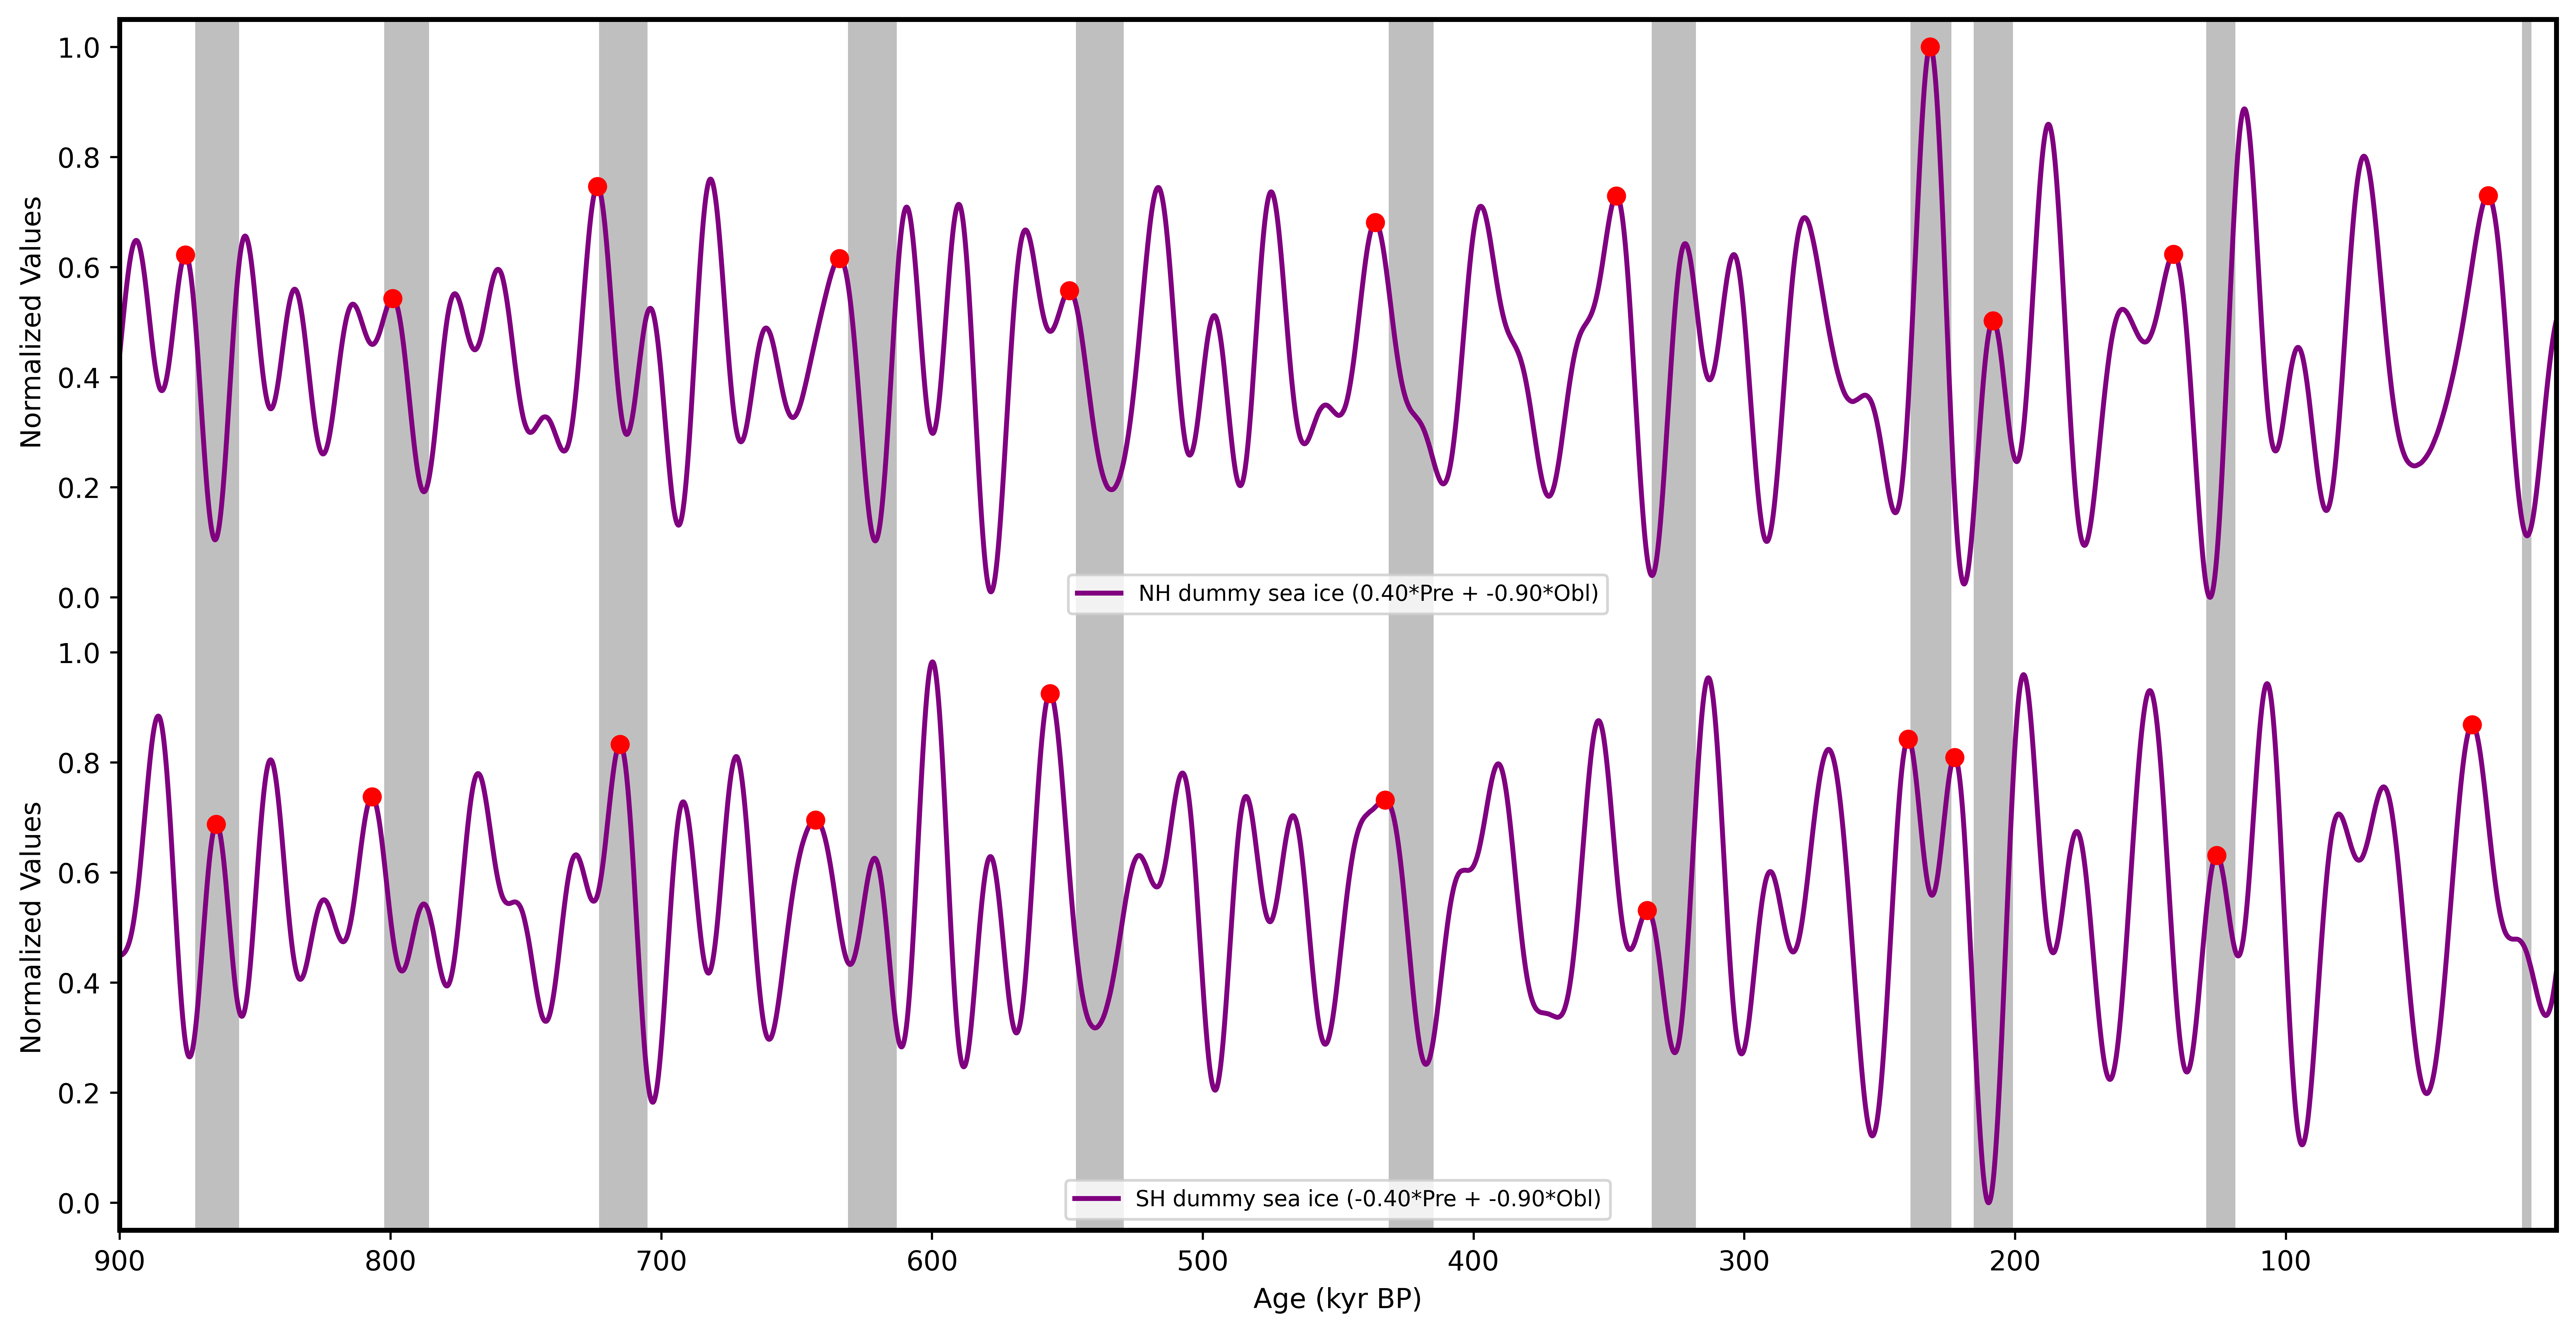

In [133]:
from scipy.stats import zscore
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

coe_pre_nh=0.4
coe_obl_nh=-0.9

coe_pre_sh=-0.4
coe_obl_sh=-0.9

# Calculate linear combination of precession and obliquity for NH and SH sea ice
linear_comb_nh = coe_pre_nh * df_pre['pre'] + coe_obl_nh * df_obl['obl']
linear_comb_sh = coe_pre_sh * df_pre['pre'] + coe_obl_sh * df_obl['obl']


def find_first_local_max_near_tt(age, data, Tt, threshold=0.5):
    local_max_indices, _ = find_peaks(data)
    local_max_age = age[local_max_indices]
    local_max_values = data[local_max_indices]

    first_local_max_near_tt = []

    for t in Tt:
        # Filter indices by threshold value
        filtered_indices = local_max_indices[local_max_values > threshold]
        filtered_ages = local_max_age[local_max_values > threshold]

        # Find local maxima that are to the right of the Tt and closest to it among those passing the threshold
        potential_indices = filtered_indices[filtered_ages >= t]
        if len(potential_indices) > 0:
            first_max_index = potential_indices[0]  # First local maximum after Tt meeting the threshold
            first_local_max_near_tt.append((age[first_max_index], data[first_max_index]))
    return first_local_max_near_tt

                
            


# define a function to normalize the data to 01
def normalize01(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


# Finding the first local maximum near Tt for NH and SH
first_local_max_near_tt_nh = find_first_local_max_near_tt(df_pre['age'].to_numpy(), normalize01(linear_comb_nh).to_numpy(), Tt,threshold=0.5)
first_local_max_near_tt_sh = find_first_local_max_near_tt(df_pre['age'].to_numpy(), normalize01(linear_comb_sh).to_numpy(), Tt,threshold=0.5)

# Setting up figure and subplots with shared x-axis
fig, axs = plt.subplots(2, 1, figsize=(16, 8), dpi=600, sharex=True)

# Plotting for NH
axs[0].plot(df_pre['age'], normalize01(linear_comb_nh), label=f'NH dummy sea ice ({coe_pre_nh:.2f}*Pre + {coe_obl_nh:.2f}*Obl)', linestyle='-', color='purple', linewidth=1.8)
# Turn off x-ticks, x-tick labels, and x-label for the first subplot
axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axs[0].set_ylabel('Normalized Values')
axs[0].legend(fontsize=8)
# axs[0].set_xlim(0, 800)
# axs[0].invert_xaxis()


# Plotting red dots for local maxima near Tt for NH
for x, y in first_local_max_near_tt_nh:
    axs[0].plot(x, y, 'ro')

# Plotting for SH
axs[1].plot(df_pre['age'], normalize01(linear_comb_sh), label=f'SH dummy sea ice ({coe_pre_sh:.2f}*Pre + {coe_obl_sh:.2f}*Obl)', linestyle='-', color='purple', linewidth=1.8)
axs[1].set_xlabel('Age (kyr BP)')
axs[1].set_ylabel('Normalized Values')
axs[1].legend(fontsize=8)
axs[1].set_xlim(900, 0)
# set x ticks
axs[1].set_xticks(np.arange(900,0,-100))
# axs[1].invert_xaxis()

# Plot vertical bands for Tt and uncertainties for SH
for t, unc in zip(Tt, Tt_unc_sigleside):
    axs[0].axvspan(t-unc, t+unc, color='gray', alpha=0.5,zorder=0,linewidth=0)
    axs[1].axvspan(t-unc, t+unc, color='gray', alpha=0.5,zorder=0,linewidth=0)

# Plotting red dots for local maxima near Tt for SH
for x, y in first_local_max_near_tt_sh:
    axs[1].plot(x, y, 'ro')

# axs[1].xaxis.set_major_locator(plt.MultipleLocator(10))

# Adjusting the linewidth of plot spines
for ax in axs:
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.8)

# set the vertical space between subplots to zero and turn of the bottom spine for the first subplot and the top spine for the second subplot
plt.subplots_adjust(hspace=0)
axs[0].spines['bottom'].set_visible(False)
axs[1].spines['top'].set_visible(False)
plt.show()
